In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tfs

#initialize variables
dataFolder = "Dynap_fine"
numjobs = 1225

#read in summary file, which contains the initial (x,y) coordinates of each job
Jobs = tfs.read('./{}/Jobs.tfs'.format(dataFolder))

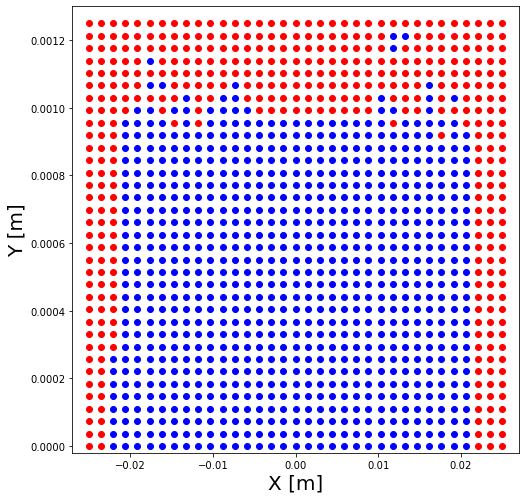

In [2]:
#initialize the plot
fig_dynap, ax_dynap = plt.subplots(figsize=(8,13))

#set plot dimensions, ideal is slightly larger than the grid so no points are on the plot boundary
x_min = -0.027
x_max = 0.027
y_min = -2e-5
y_max = 1.3e-3
ratio = (x_max-x_min)/(y_max-y_min) # ratio is calculated so that the grid spacing will be square
ax_dynap.set_xlim([x_min,x_max])
ax_dynap.set_ylim([y_min,y_max])
ax_dynap.set_aspect(ratio) 

#label and title plot
ax_dynap.set_xlabel("X [m]", fontsize=20)
ax_dynap.set_ylabel("Y [m]", fontsize=20)

Lost=[]
Turns=[]

# check data log files for each job
for i in range(0,(numjobs),1):
    # temporarily store initial (x,y) position of the particle in this job
    xi = Jobs.loc[i]['XCOORD']
    yi = Jobs.loc[i]['YCOORD']
    #check if the particle was lost, currently the loss.tfs file for a transmitted particle is not read properly
    #so a value error indicates successful transmission
    try:
        loss = tfs.read('./{}/Job.{}/Outputdata/loss.tfs'.format(dataFolder,i), index = "NUMBER")
        survived = 0
        Lost.append(True)
        turns_survived = loss.loc[1]['TURN']
        Turns.append(turns_survived)
    except ValueError:
        survived = 1
        Lost.append(False)
        turns_survived = 2500
        Turns.append(turns_survived)
        
    if survived:
        plt.plot(xi,yi,'ob')
    else:
        plt.plot(xi,yi,'or')       

Jobs['Lost']=Lost
Jobs['Turns_survived']=Turns

plt.show()

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle

import itertools

def plot_DA_as_line(ax, df, mapping={'X':'SIGMAX', 'Y':'SIGMAY', 'Loss': 'Lost'}):
    
    da_boundary= find_DA(df, mapping)
    ax.plot(da_boundary['X'],
            da_boundary['DA'],
            linestyle='-',
            linewidth=2,
            color='black',
            label='DA'
           )
    
def find_DA(df, mapping):
    
    df=df.groupby(mapping['X'])
    
    xaxis=[]
    boundary=[]
    for x, data in df:
        xaxis.append(x)
        # finds the largest amplitude under which all particles have survived
        # cum sum over the bool column Loss, all entries with 0 have stable particle below, find index of last entry and use amplitude
        data=data[data[mapping['Y']]>0]
        surviving_particles = data.loc[data[mapping['Loss']].cumsum()==0]
        if surviving_particles.empty:
            boundary.append(0)
        else:
            boundary.append(
                data.loc[surviving_particles.index[-1]][mapping['Y']]
                )
    return pd.DataFrame(data={'X': xaxis, 'DA':boundary}) 
        
        
def add_beam_ellipse(ax, loc=[0,0], beam={'betax':1, 'emitx':1e-9, 'nx':5, 'betay':1, 'emity':1e-9, 'ny':5}, sigma=False):
    
    if sigma:
        beamsize = {plane: beam[f'n{plane.lower()}'] for plane in ('X', 'Y')}
    else:
        beamsize = {plane: beam[f'n{plane.lower()}']*np.sqrt( beam[f'beta{plane.lower()}']*beam[f'emit{plane.lower()}'] ) for plane in ('X', 'Y')}
    
    ell = Ellipse(xy=loc, width=2*beamsize['X'], height=2*beamsize['Y'], edgecolor='black', fill=None, linewidth=2)
    ax.add_artist(ell)
    
def add_septum(ax, center_loc=[0,0], height=1, width=1):
    
    sept = Rectangle(xy=center_loc-np.array([width,height])/2., width=width, height=height, edgecolor='black', fill=None, linewidth=2)
    ax.add_artist(sept) 

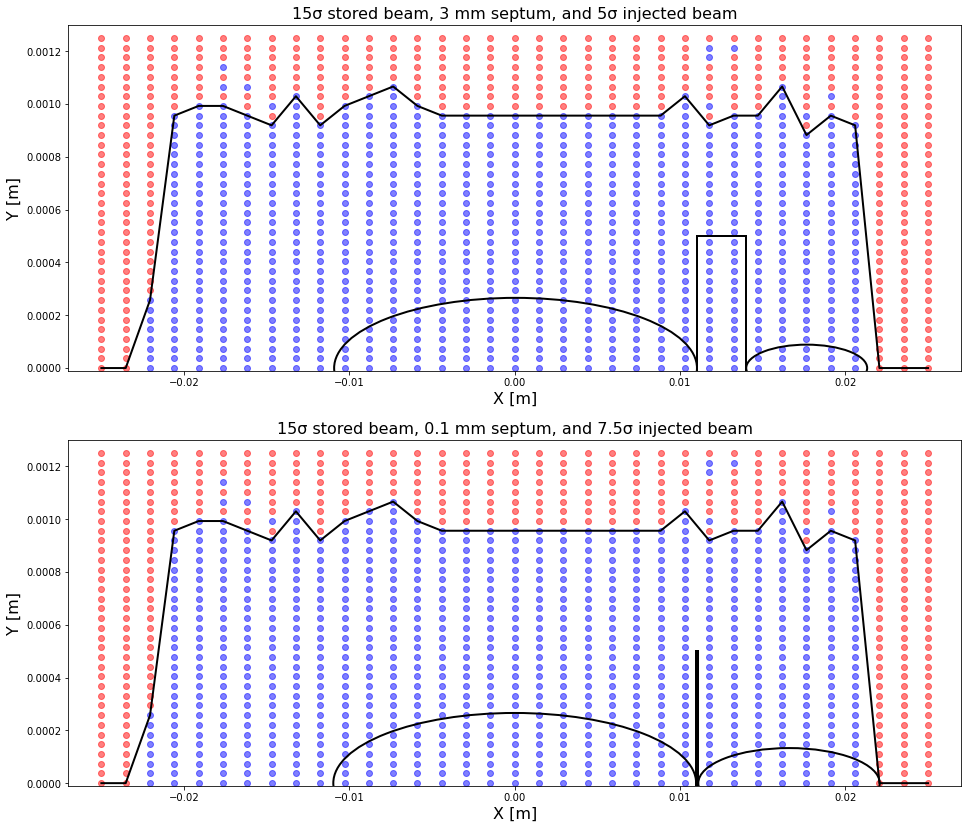

In [5]:
if __name__ == "__main__":

    sigma_limits=[-12,12]
    coord_limits_x=[-0.027,0.027]
    coord_limits_y=[-1e-5,1.3e-3]

    sigma_range=np.array(list(itertools.product(np.linspace(sigma_limits[0], sigma_limits[1], 25, endpoint=True), repeat=2)))
    coord_range=np.array(list(itertools.product(np.linspace(coord_limits_x, coord_limits_y, 25, endpoint=True), repeat=2)))


    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,14))


    ax[0].scatter(Jobs['XCOORD'][Jobs['Lost']==False], Jobs['YCOORD'][Jobs['Lost']==False], color='blue', alpha=0.5, label='Surviving')
    ax[0].scatter(Jobs['XCOORD'][Jobs['Lost']==True], Jobs['YCOORD'][Jobs['Lost']==True], color='red', alpha=0.5, label='Lost')
    ax[1].scatter(Jobs['XCOORD'][Jobs['Lost']==False], Jobs['YCOORD'][Jobs['Lost']==False], color='blue', alpha=0.5, label='Surviving')
    ax[1].scatter(Jobs['XCOORD'][Jobs['Lost']==True], Jobs['YCOORD'][Jobs['Lost']==True], color='red', alpha=0.5, label='Lost')


    plot_DA_as_line(ax[0], Jobs, mapping={'X':'XCOORD', 'Y':'YCOORD', 'Loss':'Lost'})
    plot_DA_as_line(ax[1], Jobs, mapping={'X':'XCOORD', 'Y':'YCOORD', 'Loss':'Lost'})

    #3mm septum + 50 um orbit variance
    add_beam_ellipse(ax[0], loc=[50e-6,0], beam={'betax':1982, 'emitx':0.27e-9, 'nx':15, 'betay':314, 'emity':1e-12, 'ny':15}, sigma=False)
    add_beam_ellipse(ax[0], loc=[0.011+0.003+0.00366,0], beam={'betax':1982, 'emitx':0.27e-9, 'nx':5, 'betay':314, 'emity':1e-12, 'ny':5}, sigma=False)
    add_septum(ax[0], center_loc=[0.011+0.0015,0], width=0.003, height=0.001)
    
    #0.1mm septum
    add_beam_ellipse(ax[1], beam={'betax':1982, 'emitx':0.27e-9, 'nx':15, 'betay':314, 'emity':1e-12, 'ny':15}, sigma=False)
    add_beam_ellipse(ax[1], loc=[0.011+0.0001+0.00549,0], beam={'betax':1982, 'emitx':0.27e-9, 'nx':7.5, 'betay':314, 'emity':1e-12, 'ny':7.5}, sigma=False)
    add_septum(ax[1], center_loc=[0.011+0.000005,0], width=0.0001, height=0.001)

    ax[0].set_xlim(coord_limits_x)
    ax[0].set_ylim(coord_limits_y)
    #ratio = (coord_limits_x[1]-coord_limits_x[0])/(coord_limits_y[1]-coord_limits_y[0]) # ratio is calculated so that the grid spacing will be square
    #ax[1].set_aspect(ratio)
    
    ax[1].set_xlim(coord_limits_x)
    ax[1].set_ylim(coord_limits_y)
    
    ax[0].set_title("15\u03C3 stored beam, 3 mm septum, and 5\u03C3 injected beam", fontsize=16)
    ax[0].set_xlabel("X [m]", fontsize=16)
    ax[0].set_ylabel("Y [m]", fontsize=16)
    ax[1].set_title("15\u03C3 stored beam, 0.1 mm septum, and 7.5\u03C3 injected beam", fontsize=16)
    ax[1].set_xlabel("X [m]", fontsize=16)
    ax[1].set_ylabel("Y [m]", fontsize=16)
    
    plt.show()